In [185]:
import os
import copy
import string
import heapq
import numpy as np
from word2number import w2n
from nltk.tree import Tree
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame
from IPython.display import Image, display

# java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 15000

import corenlp

import stanza

nlp = stanza.Pipeline(
    "en",
    processors={"tokenize": "gum", "pos": "gum",
                "lemma": "gum", "depparse": "gum"},
    use_gpu=True,
)

os.environ["CORENLP_HOME"] = "./NaturalLanguagePipeline\lib\stanford-corenlp-4.1.0"

relations = [
    "acl",
    "acl:relcl",
    "advcl",
    "advmod",
    "advmod:count",
    "amod",
    "appos",
    "aux",
    "aux:pass",
    "case",
    "cc",
    "cc:preconj",
    "ccomp",
    "clf",
    "compound",
    "compound:prt",
    "conj",
    "cop",
    "csubj",
    "csubj:pass",
    "dep",
    "det",
    "det:predet",
    "discourse",
    "dislocated",
    "expl",
    "fixed",
    "flat",
    "goeswith",
    "iobj",
    "list",
    "mark",
    "nmod",
    "nmod:poss",
    "nmod:npmod",
    "nmod:tmod",
    "nmod:count",
    "nsubj",
    "nsubj:pass",
    "nummod",
    "obj",
    "obl",
    "obl:npmod",
    "obl:tmod",
    "orphan",
    "parataxis",
    "punct",
    "reparandum",
    "root",
    "vocative",
    "xcomp"
]

2020-11-08 01:18:03 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | gum       |
| pos       | gum       |
| lemma     | gum       |
| depparse  | gum       |
| ner       | ontonotes |

2020-11-08 01:18:03 INFO: Use device: gpu
2020-11-08 01:18:03 INFO: Loading: tokenize
2020-11-08 01:18:03 INFO: Loading: pos
2020-11-08 01:18:04 INFO: Loading: lemma
2020-11-08 01:18:04 INFO: Loading: depparse
2020-11-08 01:18:05 INFO: Loading: ner
2020-11-08 01:18:06 INFO: Done loading processors!


In [2]:
# java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 15000


def dependencyParse(sentence, parser="stanford"):
    if parser == "stanford":
        return stanfordParse(sentence)
    elif parser == "stanza":
        return stanzaParse(sentence)


def stanzaParse(sentence):
    postag = {}
    words = {}
    parsed = nlp(sentence)
    parse_tree = []
    for sent in parsed.sentences:
        for word in sent.words:
            tree_node = postProcess(sent, word, postag, words)
            if len(tree_node) > 0:
                parse_tree.append(tree_node)

    # for tree_node in parse_tree:
    #    printTree(tree_node, postag, words)
    return parse_tree, postag, words


def postProcess(sent, word, postag, words):
    wordID = int(word.id)
    if wordID not in words:
        postag[word.text] = (wordID, word.xpos)
        words[wordID] = (word.text, word.xpos)
    if word.deprel != "punct":
        tree_node = [word.deprel, wordID,
                     word.head if word.head > 0 else "root"]
        return tree_node
    return []


def printTree(tree, tag, word):
    if tree[0] != "root":
        print(
            f"word: {word[tree[1]][0]}\thead: {word[tree[2]][0]}\tdeprel: {tree[0]}",
            sep="\n",
        )


def stanfordParse(text):
    with corenlp.CoreNLPClient(
        annotators="tokenize ssplit pos lemma depparse".split()
    ) as client:
        ann = client.annotate(text)
        sentence = ann.sentence[0]
        words = {}
        for token in sentence.token:
            if not token.word in string.punctuation:
                words[token.tokenEndIndex] = [token.word, token.pos]

        deps = []
        targets = {}
        for edge in sentence.basicDependencies.edge:
            if edge.dep != "punct":
                targets[edge.target] = edge.dep
                deps.append([edge.dep, edge.target, edge.source])

        postags = {}
        maxroot = 0
        root = ""
        rooted = False

        for wordid in words:
            word = words[wordid][0]
            if not wordid in targets:
                if wordid > maxroot:
                    maxroot = wordid
                    root = wordid
                    rooted = True
                elif not rooted and "acl" in targets[wordid]:
                    maxroot = wordid
                    root = wordid
                    rooted = True
            postags[word] = [wordid, words[wordid][1]]
        deps.append(["root", root, "root"])

        for token in sentence.token:
            if not token.tokenEndIndex in words:
                words[token.tokenEndIndex] = [token.word, token.pos]
    return deps, postags, words


In [217]:
from nltk.parse.corenlp import CoreNLPDependencyParser
dep_parser = CoreNLPDependencyParser(url='http://localhost:9000')
dep_parser = CoreNLPDependencyParser(url='http://localhost:9000')
parses = dep_parser.parse('What is the airspeed of an unladen swallow ?'.split())
for parse in parses:
    words = {}
    for token in parse:
        if token > 0:
            words[token] = [parse[token].word, parse[token].tag]
            
    for governor, dep, dependent in parse.triples():
        
        
    
    print(parse)

defaultdict(<function DependencyGraph.__init__.<locals>.<lambda> at 0x000001BA5BF47288>,
            {0: {'address': 0,
                 'ctag': 'TOP',
                 'deps': defaultdict(<class 'list'>, {'ROOT': [1]}),
                 'feats': None,
                 'head': None,
                 'lemma': None,
                 'rel': None,
                 'tag': 'TOP',
                 'word': None},
             1: {'address': 1,
                 'ctag': 'WP',
                 'deps': defaultdict(<class 'list'>,
                                     {'cop': [2],
                                      'nsubj': [4],
                                      'punct': [9]}),
                 'feats': '_',
                 'head': 0,
                 'lemma': 'what',
                 'rel': 'ROOT',
                 'tag': 'WP',
                 'word': 'What'},
             2: {'address': 2,
                 'ctag': 'VBZ',
                 'deps': defaultdict(<class 'list'>, {}),
          

In [3]:
class BinaryDependencyTree:
    def __init__(self, val, left, right, key, wid=None, npos=None):
        self.val = val
        self.parent = ""
        self.left = left
        self.right = right
        self.mark = "0"
        self.id = wid
        self.npos = npos
        self.key = key

    def isTree(self):
        return not (type(self.left) is str and type(self.right) is str)

    def getVal(self):
        return self.val

    def getLeft(self):
        return self.left

    def getRight(self):
        return self.right

In [539]:
class Binarizer:
    def __init__(self, parseTable=None, postag=None, words=None):
        self.postag = postag
        self.parseTable = parseTable
        self.words = words
        self.id = 0

    def process_not(self, children):
        if len(children) > 1:
            if children[0][0] == "advmod":
                if self.words[children[1][1]][0] == "not":
                    return [children[1]]
        return children

    def compose(self, head):
        children = list(filter(lambda x: x[2] == head, self.parseTable))
        children.sort(key=(lambda x: abs(x[2]-x[1])), reverse=True)
        children = self.process_not(children)
        if len(children) == 0:
            word = self.words[head][0]
            tag = self.words[head][1]
            binaryTree = BinaryDependencyTree(
                word, "N", "N", self.id, head, tag)
            self.id += 1
            return binaryTree, [binaryTree.key]
        else:
            topDep = children[0]
        self.parseTable.remove(topDep)

        left, left_rel = self.compose(topDep[1])
        right, right_rel = self.compose(topDep[2])
        binaryTree = BinaryDependencyTree(topDep[0], left, right, self.id)

        binaryTree.left.parent = binaryTree
        binaryTree.right.parent = binaryTree

        left_rel.append(binaryTree.key)
        self.id += 1
        return binaryTree, left_rel + right_rel

    def binarization(self):
        self.id = 0
        self.relation = []
        root = list(filter(lambda x: x[0] == "root", self.parseTable))[0][1]
        return self.compose(root)


In [560]:
negate_mark = {
    "+": "-",
    "-": "+",
    "=": "="
}

det_mark = {
    "det:univ": ("+", "-"),
    "det:exist": ("+", "+"),
    "det:limit": ("+", "="),
    "det:negation": ("+", "-")
}

det_type_words = {
    "det:univ": ["all", "every", "each", "any"],
    "det:exist": ["a", "an", "some", "double", "triple"],
    "det:limit": ["such", "both", "the", "this", "that",
                  "those", "these", "my", "his", "her",
                  "its", "either", "both", "another"],
    "det:negation": ["no", "neither", "never"]
}

negtive_implicative = ["refuse", "reject", "oppose", "forget",
                       "hesitate", "without", "disapprove", "disagree",
                       "eradicate", "erase", "dicline", "eliminate",
                       "decline", "resist", "block", "stop", "hault",
                       "disable", "disinfect", "disapear", "disgard",
                       "disarm", "disarrange", "disallow", "discharge",
                       "disbelieve", "disclaim", "disclose", "disconnect",
                       "disconnect", "discourage", "discredit", "discorporate",
                       "disengage", "disentangle", "dismiss", "disobeye",
                       "distrust", "disrupt", "suspen", "suspend ",
                       "freeze", "remove", "refused"
                       ]


def det_type(word):
    for det in det_type_words:
        if word.lower() in det_type_words[det]:
            return det


arrows = {
    "+": "\u2191",
    "-": "\u2193",
    "=": "=",
    "0": ""
}


def btreeToList(binaryDepdency, length, annotate=True, verbose=0):
    annotated = []

    def toList(tree):
        treelist = []
        if tree.getVal() not in relations:
            treelist.append(tree.npos)
            if tree.getVal() == "n't":
                tree.val = "not"
            word = tree.getVal() + arrows[tree.mark]
            if verbose == 2:
                word += str(tree.key)
            index = tree.id
            if annotate:
                heapq.heappush(annotated, (int(index), word))
            treelist.append(word)
        else:
            word = tree.getVal() + arrows[tree.mark]
            if verbose == 2:
                word += str(tree.key)
            treelist.append(word)

        left = tree.getLeft()
        right = tree.getRight()

        if left is not 'N':
            treelist.append(toList(left))

        if right is not 'N':
            treelist.append(toList(right))

        return treelist
    return toList(binaryDepdency), annotated


def convert2vector(result):
    result_vec = []
    if type(result) is "str":
        result_ls = result.split()
    else:
        result_ls = result
    for word in result_ls:
        if arrows['+'] in word:
            result_vec.append(1)
        elif arrows['-'] in word:
            result_vec.append(-1)
        elif arrows['='] in word:
            result_vec.append(0)
    return result_vec

In [529]:
def jupyter_draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 14 bold'
    tc['leaf_font'] = 'arial 14'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 20, 20)
    cf.print_to_file('../data/tree_img/tree.ps')
    cf.destroy()
    os.system('magick convert ../data/tree_img/tree.ps ../data/tree_img/tree.png')
    display(Image(filename='../data/tree_img/tree.png'))

In [588]:
class Polarizer:
    def __init__(self, dependtree=None, relation=None):
        self.dependtree = dependtree
        self.sentence_head = []
        self.relation = relation
        self.polarize_function = {
            "acl": self.polarize_acl_relcl,
            "acl:relcl": self.polarize_acl_relcl,
            "advcl": self.polarize_acl_relcl,
            "advmod": self.polarize_advmod,
            "advmod:count": self.polarize_advmod,
            "amod": self.polarize_amod,
            "appos": self.polarize_inherite,
            "aux": self.polarize_aux,
            "aux:pass": self.polarize_aux,
            "case": self.polarize_case,
            "cc": self.polarize_cc,
            "cc:preconj": self.polarize_det,
            "ccomp": self.polarize_ccomp,
            "compound": self.polarize_inherite,
            "compound:prt": self.polarize_inherite,
            "conj": self.polarize_inherite,
            "cop": self.polarize_inherite,
            "csubj": self.polarize_nsubj,
            "csubj:pass": self.polarize_nsubj,
            "dep": self.polarize_dep,
            "det": self.polarize_det,
            "det:predet": self.polarize_det,
            "discourse": self.polarize_inherite,
            "expl": self.polarize_expl,
            "fixed": self.polarize_inherite,
            "flat": self.polarize_inherite,
            "goeswith": self.polarize_inherite,
            "iobj": self.polarize_inherite,
            "mark": self.polarize_inherite,
            "nmod": self.polarize_nmod,
            "nmod:npmod": self.polarize_nmod,
            "nmod:tmod": self.polarize_nmod,
            "nmod:poss": self.polarize_nmod_poss,
            "nsubj": self.polarize_nsubj,
            "nsubj:pass": self.polarize_nsubj,
            "nummod": self.polarize_nummod,
            "obj": self.polarize_obj,
            "obl": self.polarize_obj,
            "obl:npmod": self.polarize_oblnpmod,
            "obl:tmod": self.polarize_inherite,
            "parataxis": self.polarize_inherite,
            "xcomp": self.polarize_obj,
        }
        self.treeLog = []
        self.polarLog = []

    def polarize_deptree(self):
        self.polarize(self.dependtree)

    def polarize(self, tree):
        if tree.isTree():
            self.polarize_function[tree.val](tree)

    def polarize_acl_relcl(self, tree):
        self.polarLog.append("polarize_acl:relcl")
        self.sentence_head.append(tree)
        right = tree.getRight()
        left = tree.getLeft()

        if tree.mark != "0":
            right.mark = tree.mark
        else:
            tree.mark = "+"
            right.mark = "+"

        left.mark = "+"
        if left.isTree():
            self.polarize(left)
        if right.isTree():
            self.polarize(right)

        tree.mark = right.mark

        if right.mark == "-" and left.npos != "VBD":
            self.negate(left, -1)
        if right.mark == "=" and left.npos != "VBD":
            self.equalize(left)

        self.sentence_head.pop()

    def polarize_advmod(self, tree):
        left = tree.getLeft()
        right = tree.getRight()

        if tree.mark != "0":
            left.mark = tree.mark
            right.mark = tree.mark
        else:
            left.mark = "+"
            right.mark = "+"

        if left.val.lower() in ["many", "most"]:
            right.mark = "="
            if isinstance(tree.parent, BinaryDependencyTree) and tree.parent.val == "amod":
                self.equalize(tree.parent.right)
            if right.isTree():
                self.polarize(right)
        elif left.val.lower() in ["not", "no", "n’t"]:
            # right.mark = "-"
            if right.isTree():
                self.polarize(right)
            self.top_down_negate(tree, "advmod", self.relation.index(left.key))
        elif left.val.lower() in ["exactly"]:
            if right.isTree():
                self.polarize(right)
            self.equalize(right)
            tree.mark = right.mark
        else:
            self.polarize_inherite(tree)

        if left.val.lower() == "when":
            self.equalize(self.dependtree)

    def polarize_amod(self, tree):
        left = tree.getLeft()
        right = tree.getRight()
        if left.val.lower() in ["many", "most"]:
            left.mark = "+"
            right.mark = "="
            tree.mark = right.mark
            if right.isTree():
                self.polarize(right)
        else:
            self.polarize_inherite(tree)

    def polarize_aux(self, tree):
        self.polarize_inherite(tree)

    def polarize_case(self, tree):
        self.polarLog.append("polarize_case")

        right = tree.getRight()
        left = tree.getLeft()

        if tree.mark != "0":
            left.mark = tree.mark
            right.mark = tree.mark
        else:
            tree.mark = "+"
            left.mark = "+"
            right.mark = "+"

        if right.val == "least":
            tree.mark = "-"
            right.mark = "+"
            left.mark = right.mark
        elif right.val == "most":
            self.top_down_negate(tree, "case", self.relation.index(tree.key))
        elif left.val == "without":
            if right.isTree():
                self.polarize(right)
            self.negate(tree, self.relation.index(left.key))
        elif right.npos == "CD":
            right.mark = "="
            if left.isTree():
                self.polarize(left)
        elif left.val.lower() == "for":
            if right.isTree():
                self.polarize(right)
            self.equalize(right)
        elif right.val == "nmod:poss":
            left.mark = "="
            if right.isTree():
                self.polarize(right)
        else:
            if left.isTree():
                self.polarize(left)
            if right.isTree():
                self.polarize(right)
                tree.mark = right.mark

    def polarize_cc(self, tree):
        right = tree.getRight()
        left = tree.getLeft()

        left.mark = "+"
        right.mark = "+"

        if right.val != "expl" and right.val != "det":
            right.mark = tree.mark

        if right.isTree():
            self.polarize(right)

        if left.id == 1:
            self.equalize(right)

    def polarize_ccomp(self, tree):
        right = tree.getRight()
        left = tree.getLeft()

        if tree.mark != "0":
            right.mark = tree.mark

        if right.isTree():
            self.polarize(right)

        left.mark = right.mark
        if left.isTree():
            self.polarize(left)

    def polarize_dep(self, tree):
        self.polarLog.append("polarize_dep")

        right = tree.getRight()
        left = tree.getLeft()

        if tree.mark != "0":
            right.mark = tree.mark
            left.mark = tree.mark
        else:
            tree.mark = "+"
            right.mark = "+"
            left.mark = "+"

        if right.isTree():
            self.polarize(right)

        if left.isTree():
            self.polarize(left)

    def polarize_det(self, tree):
        self.polarLog.append("polarize_det")
        right = tree.getRight()
        left = tree.getLeft()

        if tree.mark != "0":
            left.mark = tree.mark
            right.mark = tree.mark
        else:
            left.mark = "+"
            right.mark = "+"

        detType = det_type(left.val)
        if detType is None:
            detType = "det:exist"
        detMark = det_mark[detType]

        right.mark = detMark[1]
        tree.mark = detMark[1]

        if right.isTree():
            self.polarize(right)

        if detType == "det:negation":
            self.top_down_negate(tree, "det", self.relation.index(tree.key))

    def polarize_expl(self, tree):
        right = tree.getRight()
        left = tree.getLeft()

        left.mark = "+"
        right.mark = "+"

        if self.dependtree.left.mark == "-":
            right.mark = "-"

        if left.isTree():
            self.polarize(left)

        if right.isTree():
            self.polarize(right)

    def polarize_nmod(self, tree):
        right = tree.getRight()
        left = tree.getLeft()

        if tree.mark != "0":
            right.mark = tree.mark
        else:
            right.mark = "+"
        left.mark = "+"

        if right.npos == "DT":
            detType = det_type(right.val)
            if detType == None:
                detType = "det:exist"
            left.mark = det_mark[detType][1]
        elif right.val.lower() in ["many", "most"]:
            left.mark = "="
        elif right.val.lower() in ["none"]:
            left.mark = "-"

        if left.isTree():
            self.polarize(left)

        if right.isTree():
            self.polarize(right)

        tree.mark = right.mark
        if right.mark == "-":
            self.negate(left, -1)
        elif right.mark == "=":
            self.equalize(left)

    def polarize_nmod_poss(self, tree):
        right = tree.getRight()
        left = tree.getLeft()

        left.mark = tree.mark
        if left.isTree():
            self.polarize(left)
        else:
            left.mark = "+"

        right.mark = tree.mark
        if self.searchDependency("det", tree.left):
            right.mark = left.mark
        if right.isTree():
            self.polarize(right)
        else:
            right.mark = "+"

    def polarize_nsubj(self, tree):
        self.polarLog.append("polarize_nsubj")
        # self.sentence_head.append(tree)
        right = tree.getRight()
        left = tree.getLeft()

        if tree.mark != "0":
            right.mark = tree.mark
            left.mark = tree.mark
        else:
            tree.mark = "+"
            right.mark = "+"
            left.mark = "+"

        if self.searchDependency("expl", right):
            self.polarize(left)
            self.polarize(right)
            return

        self.polarize(right)

        if left.val.lower() == "that":
            self.equalize(right)
        if not isinstance(tree.parent, str):
            if tree.parent.left.val.lower() == "that":
                self.equalize(left)

        if left.isTree():
            self.polarize(left)
        else:
            if left.val.lower() in ["nobody"]:
                self.negate(tree, self.relation.index(tree.key))

        if tree.mark == "0":
            tree.mark = right.mark

        if left.npos == "NN":
            left.mark = tree.mark
            
        if right.val.lower() in negtive_implicative:
            tree.mark = "-"

    def polarize_nummod(self, tree):
        self.polarLog.append("polarize_nummod")
        right = tree.getRight()
        left = tree.getLeft()

        if tree.mark != "0":
            left.mark = tree.mark
            right.mark = tree.mark
        else:
            left.mark = "+"
            right.mark = "+"

        if left.val.lower() in ["one", "1"]:
            left.mark = "="

        if tree.parent == "compound":
            right.mark = left.mark

        if left.npos == "CD":
            left.mark = "-"
            right.mark = "+"

        if left.isTree():
            self.polarize(left)
            if left.mark == "=":
                right.mark = left.mark
                tree.mark = left.mark
        elif left.id == 1:
            left.mark = "="

        if right.isTree():
            self.polarize(right)

    def polarize_obj(self, tree):
        right = tree.getRight()
        left = tree.getLeft()

        if tree.mark != "0":
            right.mark = tree.mark
        else:
            right.mark = "+"
            tree.mark = "+"
        left.mark = "+"

        if right.isTree():
            self.polarize(right)

        if left.isTree():
            self.polarize(left)
            
        if right.mark == "-" or right.val.lower() in negtive_implicative:
            self.negate(left, -1)
            

    def polarize_obl(self, tree):
        self.polarLog.append("polarize_obl")

        right = tree.getRight()
        left = tree.getLeft()

        if tree.mark != "0":
            right.mark = tree.mark
        else:
            right.mark = "+"
        left.mark = "+"

        if right.isTree():
            self.polarize(right)

        if left.isTree():
            self.polarize(left)

        if right.mark == "-":
            self.negate(left, -1)

    def polarize_inherite(self, tree):
        right = tree.getRight()
        left = tree.getLeft()

        if tree.mark != "0":
            right.mark = tree.mark
            left.mark = tree.mark
        else:
            right.mark = "+"
            left.mark = "+"

        if right.isTree():
            self.polarize(right)

        if left.val.lower() == "there":
            left.mark = "+"
        if left.isTree():
            self.polarize(left)

    def polarize_oblnpmod(self, tree):
        right = tree.getRight()
        left = tree.getLeft()

        if left.isTree():
            self.polarize(left)
        right.mark = left.mark
        if right.isTree():
            self.polarize(right)

    def searchDependency(self, deprel, tree):
        if tree.val == deprel:
            return True
        else:
            right = tree.getRight()
            left = tree.getLeft()

            leftFound = False
            rightFound = False

            if not isinstance(right, str) and right.isTree():
                rightFound = self.searchDependency(deprel, right)

            if not isinstance(left, str) and left.isTree():
                leftFound = self.searchDependency(deprel, left)

            return leftFound or rightFound

    def verbMarkReplace(self, tree, mark):
        if isinstance(tree, str):
            return
        if tree.npos is not None and "VB" in tree.npos:
            tree.mark = mark
        self.verbMarkReplace(tree.left, mark)
        self.verbMarkReplace(tree.right, mark)

    def equalize(self, tree):
        if tree.isTree():
            self.equalize(tree.getRight())
            self.equalize(tree.getLeft())
            if tree.mark != "0":
                tree.mark = "="
        else:
            if tree.npos != "CC" and tree.val.lower() != "when":
                tree.mark = "="

    def negate_condition(self, tree, anchor):
        not_truth_connection = not tree.val in ["and", "or"]
        not_empty_mark = tree.mark != "0"
        return not_empty_mark and not_truth_connection

    def top_down_negate(self, tree, deprel, anchor):
        if not isinstance(tree.parent, BinaryDependencyTree):
            return
        if tree.parent.left.val == deprel:
            self.negate(tree.parent.left, anchor)
            self.negate(tree.parent.right, -1)
        elif tree.parent.right.val == deprel:
            self.negate(tree.parent.right, anchor)
            self.negate(tree.parent.left, -1)

    def negate(self, tree, anchor):
        if isinstance(tree, str):
            return
        if tree.val == "cc" and tree.right.val in ["expl", "nsubj", "det"]:
            return
        if tree.isTree():
            print(tree.val)
            if self.relation.index(tree.key) > anchor or "nsubj" in tree.val:
                print(tree.val)
                self.negate(tree.getRight(), anchor)
                self.negate(tree.getLeft(), anchor)
                if self.negate_condition(tree, anchor):
                    tree.mark = negate_mark[tree.mark]
        else:
            if self.relation.index(tree.key) > anchor and self.negate_condition(tree, anchor):
                if tree.npos != "EX":
                    tree.mark = negate_mark[tree.mark]


In [572]:
def run_polarize_pipeline(sentences, annotations=[], verbose=0):
    binarizer = Binarizer()
    for i in range(len(sentences)):
        sent = sentences[i]
        print()
        print()
        print(sent)
            
        tree, postag, words = dependencyParse(sent, "stanza")
        parseTreeCopy = copy.deepcopy(tree)

        # binarization
        binarizer.parseTable = parseTreeCopy
        binarizer.postag = postag
        binarizer.words = words
        binaryDepdency, relation = binarizer.binarization()
        
        if verbose == 2:
            sexpression, annotated = btreeToList(binaryDepdency, len(words), False, 0)
            sexpression = str(sexpression).replace(',', ' ').replace("'", '')
            #print(sexpression)
            sexpression = sexpression.replace('[', '(').replace(']', ')')
            btreeViz = Tree.fromstring(sexpression)
            jupyter_draw_nltk_tree(btreeViz)

        # polarization
        polarizer = Polarizer(binaryDepdency, relation)
        polarizer.polarize_deptree()

        # postprocessing
        sexpression, annotated = btreeToList(binaryDepdency, len(words), True, 0)
        sexpression = str(sexpression).replace(',', ' ').replace("'", '').replace('[', '(').replace(']', ')')
        if verbose == 2:
            print(sexpression)

        #visualization
        result = []
        while annotated:
            next_item = heapq.heappop(annotated)
            result.append(next_item[1])
            
        result = '%s' % ', '.join(map(str, result)).replace(",", " ")
        print(result)
        #vec = convert2vector(result) 
        #if len(annotations) > 0:
            #vec_val = convert2vector(annotations[i])
            #if len(vec) == len(vec_val):
                #if np.sum(np.subtract(vec,vec_val)) == 0:
                    #print(sexpression.replace('(', '[').replace(')', ']'))
        
        btreeViz = Tree.fromstring(sexpression)
        jupyter_draw_nltk_tree(btreeViz)
        
        if verbose == 3:
            print(polarizer.treeLog)
            

In [583]:
"all black mammals saw exactly 5 stallions who danced", "most newborn cats, who ran, moved", 

('all black mammals saw exactly 5 stallions who danced',
 'most newborn cats, who ran, moved')



A jet is flying
A↑  jet↑  is↑  flying↑


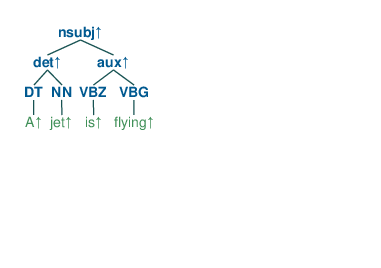

In [589]:
run_polarize_pipeline(["A jet is flying"], verbose=0)



at most, 6 old mammals, who swam did not sniff all black quadrupeds


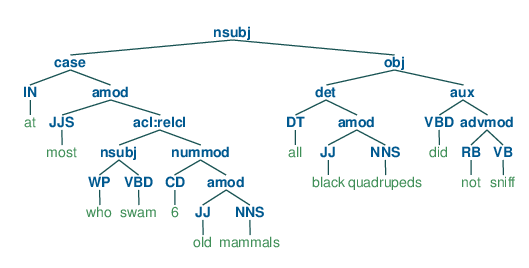

(nsubj↑  (case=  (IN  at↑)  (amod=  (JJS  most↑)  (acl:relcl=  (nsubj=  (WP  who=)  (VBD  swam=))  (nummod=  (CD  6↓)  (amod↑  (JJ  old↑)  (NNS  mammals↑))))))  (obj↑  (det↓  (DT  all↑)  (amod↓  (JJ  black↓)  (NNS  quadrupeds↓)))  (aux↑  (VBD  did↓)  (advmod↓  (RB  not↑)  (VB  sniff↓)))))
at↑  most↑  6↓  old↑  mammals↑  who=  swam=  did↓  not↑  sniff↓  all↑  black↓  quadrupeds↓


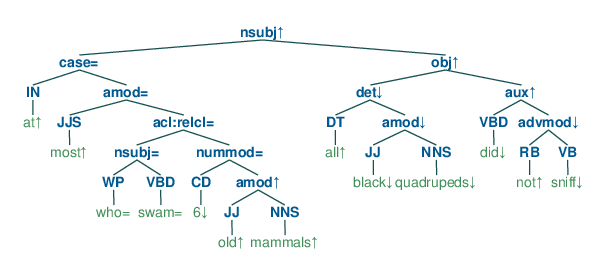

In [554]:
run_polarize_pipeline(["at most, 6 old mammals, who swam did not sniff all black quadrupeds"], verbose=2)



There is no adult in the amphitheater talking to a boy


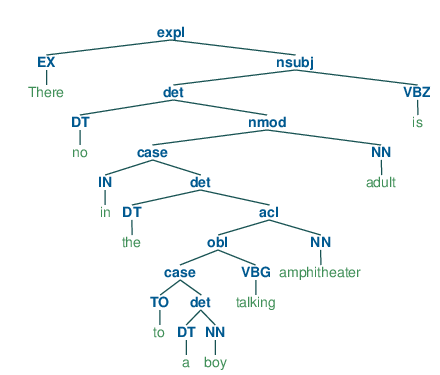

(expl  (EX  There↑)  (nsubj↑  (det↓  (DT  no↑)  (nmod↓  (case=  (IN  in↓)  (det=  (DT  the↓)  (acl=  (obl=  (case=  (TO  to=)  (det=  (DT  a=)  (NN  boy=)))  (VBG  talking=))  (NN  amphitheater=))))  (NN  adult↓)))  (VBZ  is↓)))
There↑  is↓  no↑  adult↓  in↓  the↓  amphitheater=  talking=  to=  a=  boy=


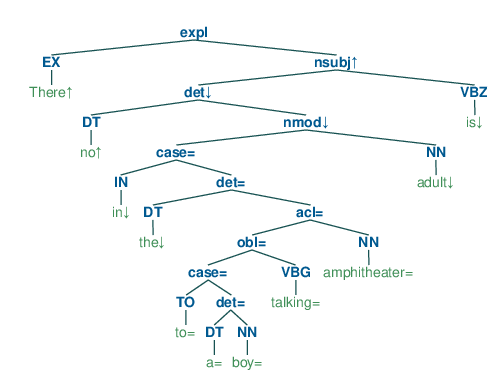

In [524]:
run_polarize_pipeline(["There is no adult in the amphitheater talking to a boy"], verbose=2)

In [ ]:
#### run_polarize_pipeline(["Jane gave three pens to every student who read all of Shakespeare's sonnets."], 2)
'''more than and as many as 
at most 
at least 
at most 
less than
only bears bance 
i only eat hot food'''
run_polarize_pipeline(["At most thirty five senators oppose the nomination.", 
                       "At least thirty five senators support the nomination", 
                       "At most five senators oppose the nomination.", 
                       "At least five senators support the nomination", 
                       "Some people who fear no animals face at least three lions",
                       "More than one out of six dentists had at least two cavities", 
                       "The old archer drank not less than six cups of mead "], verbose=0)
#run_polarize_pipeline(["At least 14 senators support the law", "At most 14 senators support the law", "At least 5 dogs sleep at night. ", "At most five dogs eat dinner.", "Some dogs eat no food"], 0)



A million grasshoppers buzzed noisily

A↑  million↓  grasshoppers↑  buzzed↑  noisily↑


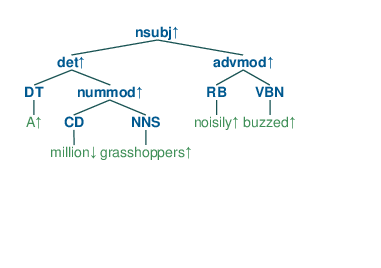



No plumber who wanted a job submitted an application

No↑  plumber↓  who↓  wanted↓  a↓  job↓  submitted↓  an↓  application↓


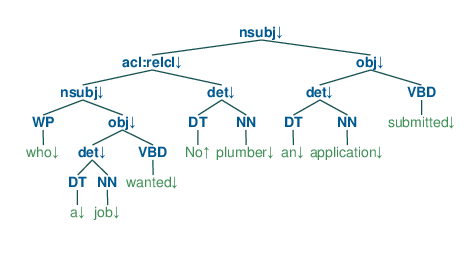



At most fourteen senators oppose

At↑  most↑  fourteen↓  senators↑  oppose↓


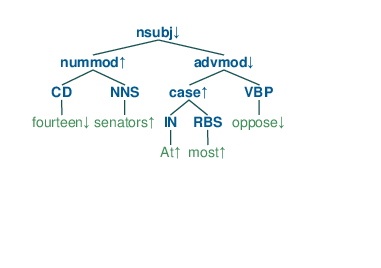



At least fourteen senators support

At↑  least↑  fourteen↓  senators↑  support↑


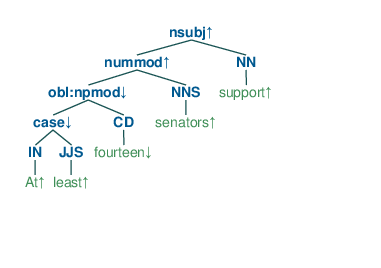



No carpenter or plumber attended the party

No↑  carpenter↓  or↑  plumber↓  attended↓  the↓  party=


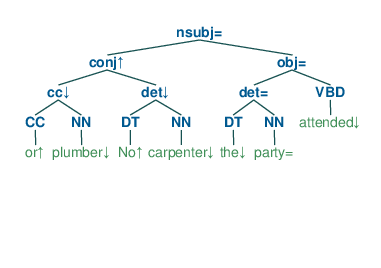



The large bones belonged to an Arapaho trader 

The↑  large=  bones=  belonged↑  to↑  an↑  Arapaho↑  trader↑


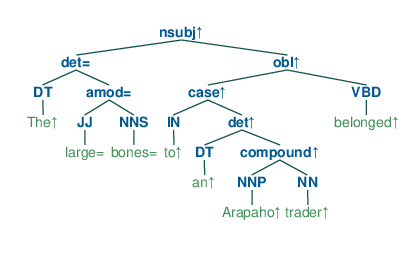



Every piano student who practices two hours a day makes progress

Every↑  piano↓  student↓  who↓  practices↓  two↑  hours↓  a↓  day↓  makes↑  progress↑


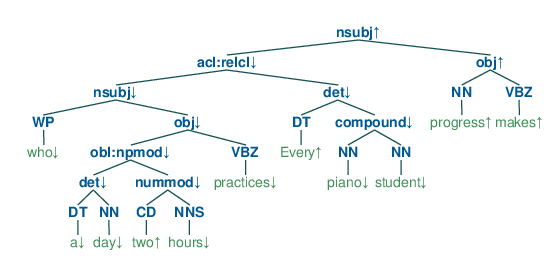



Five people can lift a piano

Five=  people↑  can↑  lift↑  a↑  piano↑


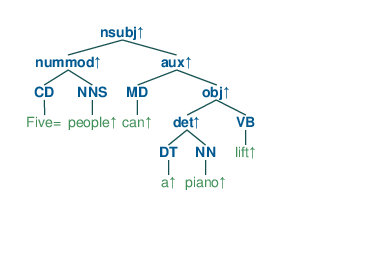



Not even six people can lift a three-ton weight

Not↑  even↑  six↑  people↓  can↓  lift↓  a↓  three↑  ton↑  weight↓


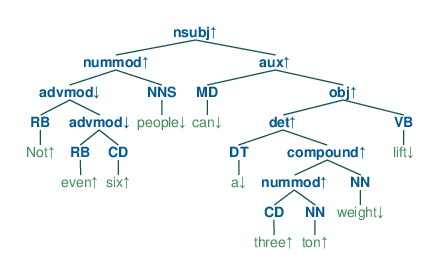



Every boy who played every sport got a gold medal

Every↑  boy↓  who↓  played↓  every↓  sport↑  got↑  a↑  gold↑  medal↑


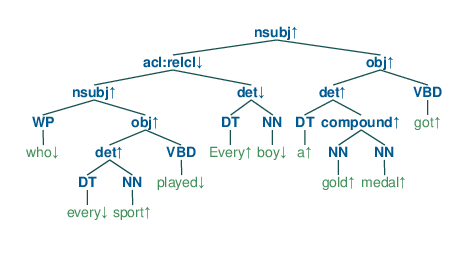



Some girl who played most sports flew to Florida

Some↑  girl↑  who↑  played↑  most↑  sports=  flew↑  to↑  Florida↑


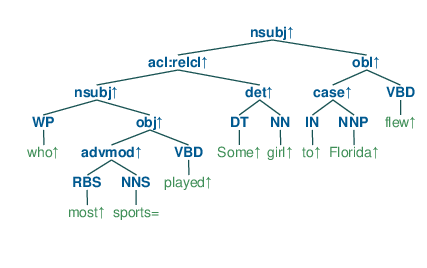



Anyone who has lived in Indiana likes persimmons

Anyone↑  who↑  has↑  lived↑  in↑  Indiana↓  likes↑  persimmons↑


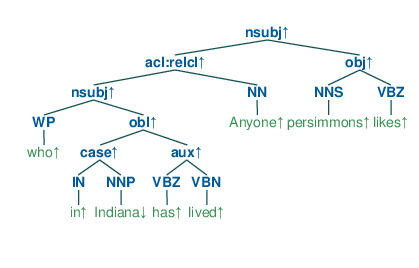



Dark black smoke wafted from the burned window frames

Dark↑  black↑  smoke↑  wafted↑  from↑  the↑  burned=  window=  frames=


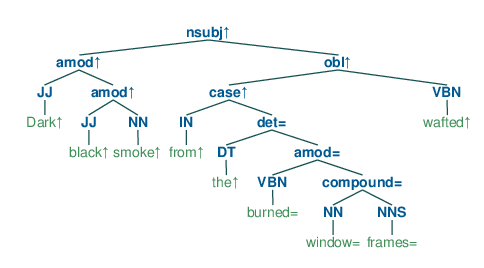



Six cats slowly prowled two streets

Six=  cats↑  slowly↑  prowled↑  two↓  streets↑


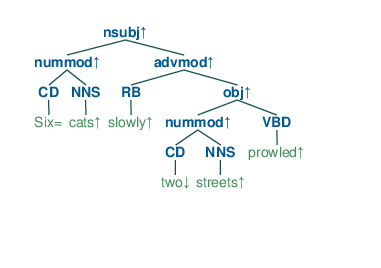



All people who love all people who love Mozart attended the concert

All↑  people↓  who↓  love↓  all↓  people↑  who↑  love↑  Mozart↑  attended↑  the↑  concert=


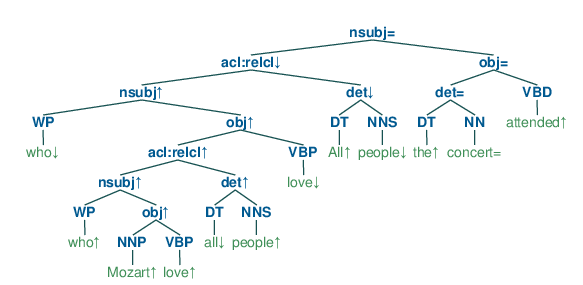



Some people who fear no animals face at least three lions

Some↑  people↑  who↑  fear↓  no↑  animals↓  face↑  at↑  least↑  three↓  lions↑


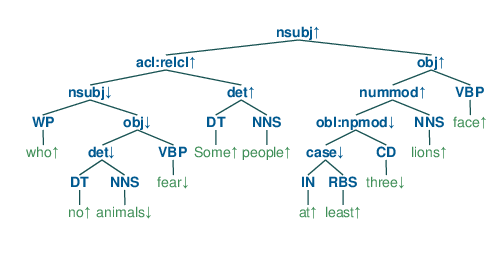



Some people who fear no ferocious animals jumped 

Some↑  people↑  who↑  fear↓  no↑  ferocious↓  animals↓  jumped↑


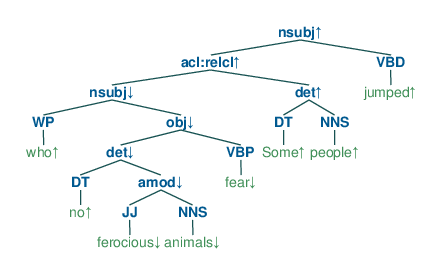



Jane gave three pens to every student who read all of Shakespeare's sonnets.

Jane↑  gave↑  three↓  pens↑  to↑  every↑  student↓  who↓  read↓  all  of=  Shakespeare↓  "s↓"  sonnets↓


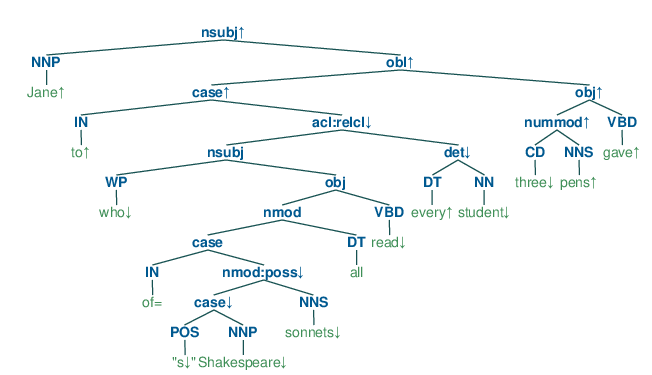



Most crows died of a rare disease

Most↑  crows=  died↑  of↑  a↑  rare↑  disease↑


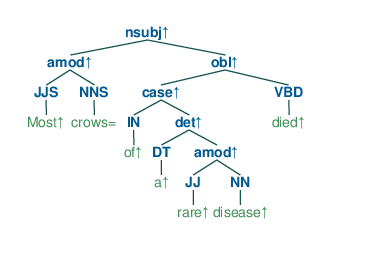



More than one out of six dentists had at least two cavities

More↓  than↓  one↓  out↓  of↓  six↓  dentists↑  had↑  at↑  least↑  two↓  cavities↑


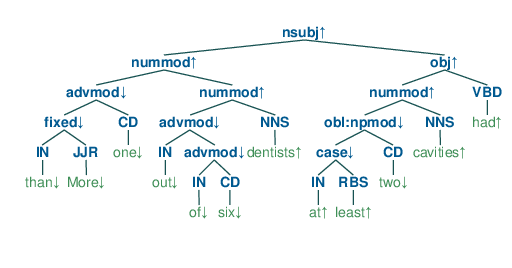



The old archer drank not less than six cups of mead 

The↑  old=  archer=  drank↓  not↑  less↓  than↓  six↓  cups↑  of↑  mead↑


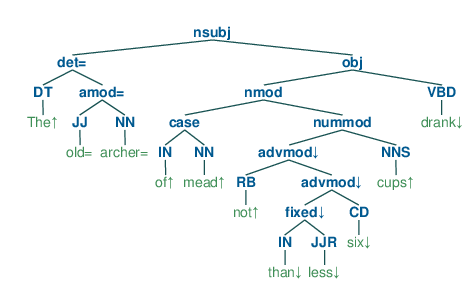



No newspapers reported no bad news

No↑  newspapers↓  reported↑  no↓  bad↑  news↑


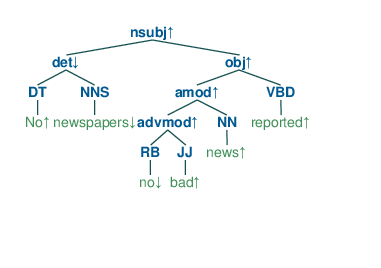



Some newspaper reported no bad news

Some↑  newspaper↑  reported↓  no↑  bad↓  news↓


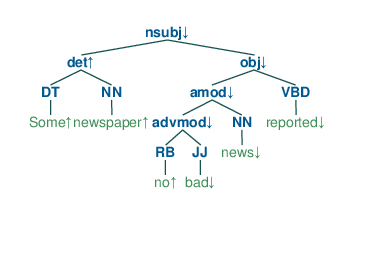



Most joggers turn left at every other corner

Most↑  joggers=  turn↑  left↑  at↑  every↑  other↓  corner↓


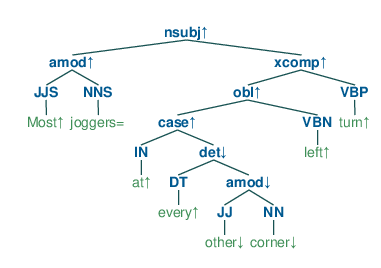

In [13]:
#filename = "monotonicity1.txt"
filename = "test_hard.txt"
valname = "test_hard.depccg.parsed.txt.polarized"
path = os.path.join('../data', filename)
val_path = os.path.join('../data', valname)
with open(path, 'r') as data:
    with open(val_path, 'r') as annotation:
        lines = data.readlines() 
        annotations = annotation.readlines()
        run_polarize_pipeline(lines, annotations, 0)
#run_polarize_pipeline(["The exchange came as Mr. Graham and Judge Barrett sought to push back on Democrats’ portrayal of the nominee as a right-wing activist chosen to undermine civil rights, the Affordable Care Act and environmental law."], 2)
#run_polarize_pipeline(["Republicans have instead worked to focus on her qualifications and emphasize her status as an accomplished working mother of seven."], 0)

In [ ]:
from nltk.corpus import wordnet as wn

emphasize = wn.synset('night.n.01')
print(emphasize.hypernyms())
print(emphasize.hyponyms())

In [ ]:
baseline = ["All dogs run", "Some dogs run", "No dog runs", 
            "All dogs eat apples", "Some dogs eat apples", "No dog eats apples", "That dog eats apples",
            "Many dogs sleep at night. ", "Most dogs sleep at night. ", "A few dogs sleep at night. ",
            "At least 5 dogs sleep at night. ", "At most five dogs eat dinner.","Five dogs are chasing cats",
            "All beautiful dogs eat apples", 
            "Some beautiful dogs eat apples", 
            "No beautiful dogs eat apples", 
            "All beautiful and smart dogs eat apples", 
            "No beautiful and smart dogs eat apples",
            "Some beautiful and smart dogs eat apples",
            "A smart and healthy person sleeps at night",
            "Every smart and healthy people sleep at night",
            "That tall and beautiful flower opens at night",
            "A man is playing the piano happily",
            "Every dog is excitedly chasing some cats",
            "No dog is excitedly chasing some cats",
            "All books here are beautifully printed and absolutely immaculate"]

Conservativity = ["No really great tenors are modest", "Some Italian tenors are great", 
              "The really ambitious tenors are Italian", "Each Italian tenors wants to be great",
              "Many great tenors are German", "Both leading tenors are excellent",
              "Neither leading tenor comes cheap",
              "At least three tenors will take part in the concert", 
              "At most two tenors will contribute their fees to charity", "One of the leading tenor is Pavarotti"
              "Leading tenors who are excellent are indispensable"]

monotonicity = ["An Irishman won the Nobel prize for literature.", "Every European has the right to live in Europe.", 
                "All Europeans have the right to live in Europe.", "Each European has the right to live in Europe.",
                "Every European is a person.",
                "Every person who has the right to live in Europe can travel freely within Europe.", 
                "An Italian became the world's greatest tenor"]

monotonicity_up_first = [
    "A Swede won a Nobel prize.",
    "Every Swede is a Scandinavian.",
    "A Scandinavian won a Nobel prize.",
    "Every Canadian resident can travel freely within Europe.",
    "Every Canadian resident is a resident of the North American continent.",
    "Every resident of the North American continent can travel freely within Europe.",
    "All Canadian residents can travel freely within Europe.",
    "Every Canadian resident is a resident of the North American continent.",
    "All residents of the North American continent can travel freely within Europe.",
    "Each Canadian resident can travel freely within Europe.",
    "Every Canadian resident is a resident of the North American continent.",
    "Each resident of the North American continent can travel freely within Europe.",
    "The residents of major western countries can travel freely within Europe.",
    "All residents of major western countries are residents of western countries.",
    "The residents of western countries have the right to live in Europe.",
    "No Scandinavian delegate finished the report on time.",
    "Some delegate finished the report on time.",
    "Some Irish delegates finished the survey on time.",
    "Some delegates finished the survey on time.",
    "Many British delegates obtained interesting results from the survey.",
    "Many delegates obtained interesting results from the survey.",
    "Several Portuguese delegates got the results published in major national newspapers.",
    "Several delegates got the results published in major national newspapers.",
    "Most Europeans who are resident in Europe can travel freely within Europe.",
    "Most Europeans can travel freely within Europe.",
    "A few female committee members are from Scandinavia.",
    "At least a few committee members are from Scandinavia.",
    "Few female committee members are from southern Europe.",
    "Few committee members are from southern Europe.",
    "Both female commissioners used to be in business.",
    "Neither female commissioner spends a lot of time at home.",
    "One of the commissioners spends a lot of time at home.",
    "At least three female commissioners spend time at home.",
    "At least three commissioners spend time at home.",
    "At most ten female commissioners spend time at home.",
    "At most ten commissioners spend time at home."
]

relative_clauses = ["Every boy who is loved by no person loves apples",
                    "Every boy who is loved by some people loves apples",
                    "Every boy who is loved by every person loves apples",
                    "Every boy who is loved by that person loves apples"]

In [2]:
from polarization import run_polarize_pipeline

In [153]:
dataset = "SEG/quantifier"
filename = "test/test.json"
path = os.path.join('../data', dataset)
path = os.path.join(path, filename)
out_path = os.path.join('../data', dataset)
out_path = os.path.join(out_path, "quantifier.txt")

In [154]:
import pandas as pd

SICK_train = pd.read_json(path, lines=True)
SICK_train.columns

Index(['sentence1', 'sentence2', 'gold_label', 'pairID', 'captionID'], dtype='object')

In [155]:
import numpy as np 

sentence_A = SICK_train['sentence1'].to_numpy()
sentence_B = SICK_train['sentence2'].to_numpy()

In [156]:
with open(out_path, 'w') as filehandle:
    for listitem in sentence_A:
        filehandle.write('%s\n' % listitem)
    for listitem in sentence_B:
        filehandle.write('%s\n' % listitem)